# Data Streaming Algorithms and Online Learning
## HW 3 - Netflix Problem Revisited
by Millis Sahar  

In [175]:
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import wordcloud as wc
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
from mpl_toolkits import mplot3d

from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

Hide warnings

In [162]:
import warnings
warnings.filterwarnings('ignore')

Disabling autoscrolling for long output:

In [161]:
%%javascript
require(
        ["notebook/js/outputarea"],
        function (oa) {
            oa.OutputArea.auto_scroll_threshold = -1;
            console.log("Setting auto_scroll_threshold to -1");
        });

<IPython.core.display.Javascript object>

# Download the MovieLens 1M dataset 
[https://grouplens.org/datasets/movielens/1m/]   
whichcontains 1 million ratings from 6000 users on 4000 movies.


###### users df

In [3]:
users_list = [i.strip().split("::") for i in open('users.dat', 'r').readlines()]
users_df = pd.DataFrame(users_list, columns = ['UserID', 'Gender', 'Age', 'Occupation','Zip-code'], dtype = int)
# users_df.head()

##### movies df

In [4]:
movies_list = [i.strip().split("::") for i in open('movies.dat', 'r').readlines()]
movies_df = pd.DataFrame(movies_list, columns = ['MovieID', 'Title', 'Genres'], dtype = int)
# movies_df.head()

##### ratings df

In [5]:
ratings_list = [i.strip().split("::") for i in open('ratings.dat', 'r').readlines()]
rating_df = pd.DataFrame(ratings_list, columns = ['UserID', 'MovieID', 'Rating', 'Timestamp'], dtype = int)
rating_df['Rating']=rating_df['Rating'].apply(pd.to_numeric)
rating_df.head()

UserID MovieID  Rating  Timestamp
0      1    1193       5  978300760
1      1     661       3  978302109
2      1     914       3  978301968
3      1    3408       4  978300275
4      1    2355       5  978824291

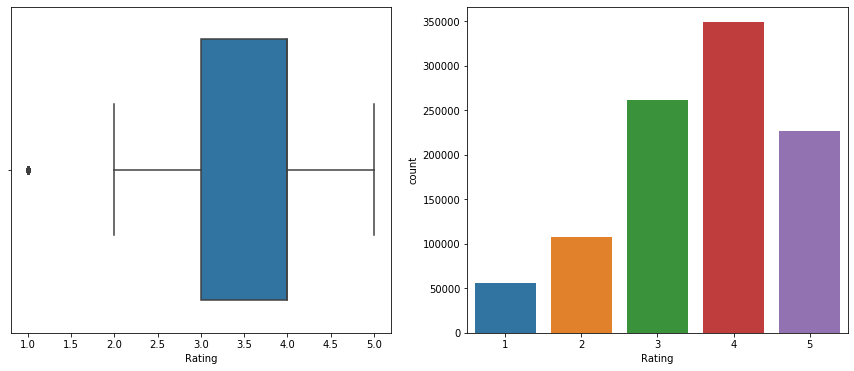

In [6]:
f, axes = plt.subplots(1, 2,figsize=(15,6))
sns.boxplot(rating_df.Rating,ax=axes[0])
sns.countplot(rating_df.Rating,ax=axes[1])
plt.show()

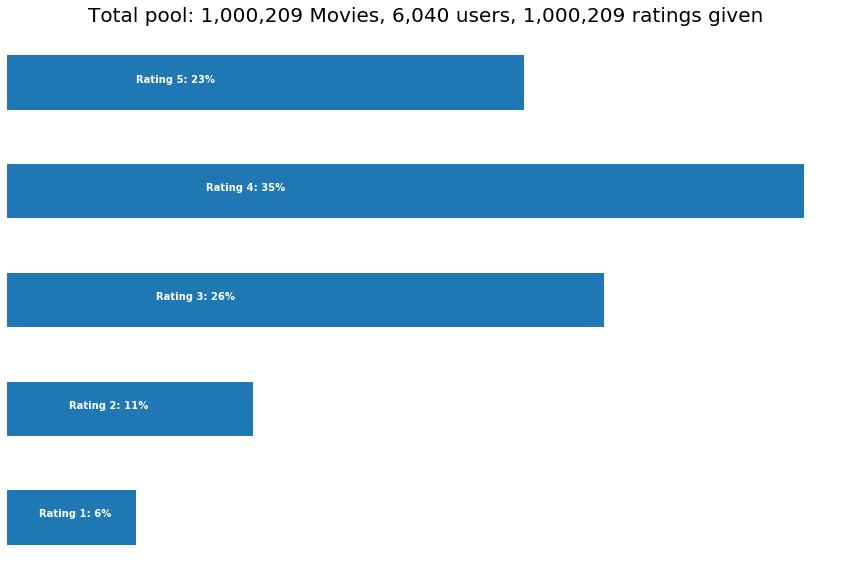

In [7]:
p = rating_df.groupby('Rating')['Rating'].agg(['count'])
movie_count = rating_df.MovieID.count()
cust_count = rating_df.UserID.nunique() 
rating_count = rating_df.UserID.count()

ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total pool: {:,} Movies, {:,} users, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')

### Movie ratings aggregated by user

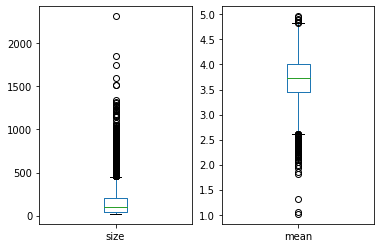

In [8]:
userRatingsAggr = rating_df.groupby(['UserID']).agg({'Rating': [np.size, np.mean]})
userRatingsAggr.reset_index(inplace=True)  # To reset multilevel (pivot-like) index
userRatingsAggr['Rating'].plot(kind='box', subplots=True)
plt.show()

I observe that most of the movies recieved around 150 rates with an average of 3.75.

### Movie ratings aggregated by movies

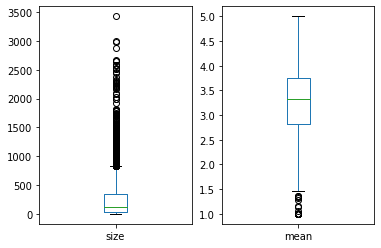

In [9]:
movieRatingsAggr = rating_df.groupby(['MovieID']).agg({'Rating': [np.size, np.mean]})
movieRatingsAggr.reset_index(inplace=True)
movieRatingsAggr['Rating'].plot(kind='box', subplots=True)
plt.show()

Most of the movies have between 10 to 500 rates with the same average rate of 3.4.

## Genres

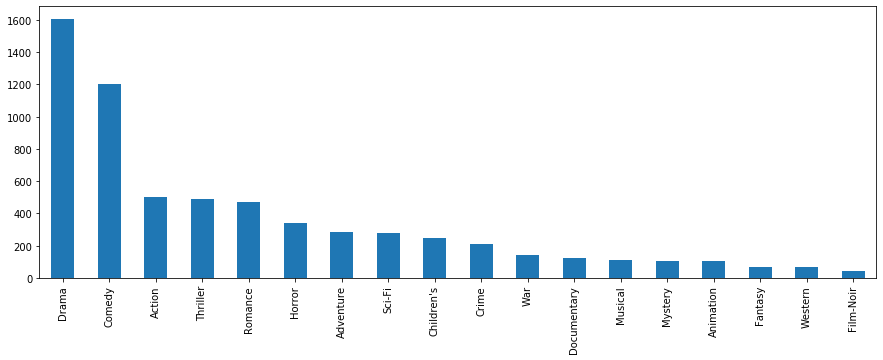

In [10]:
movies_df['genres']  = movies_df.Genres.str.split("|", n = 10, expand = False)  

def count_multiple(df,column):    
    multiple= df[column]
    multiple= multiple.apply(pd.Series.value_counts)
    multiple = multiple.sum(axis = 0, skipna = True)
    multiple = multiple.sort_values(ascending=False).nlargest(20)
    return multiple

genres_count = count_multiple(movies_df,'genres')
plt.figure(figsize=(15,5))
genres_count.plot.bar()
plt.show()

Drama and comedy are the most present comparing to other catagories.

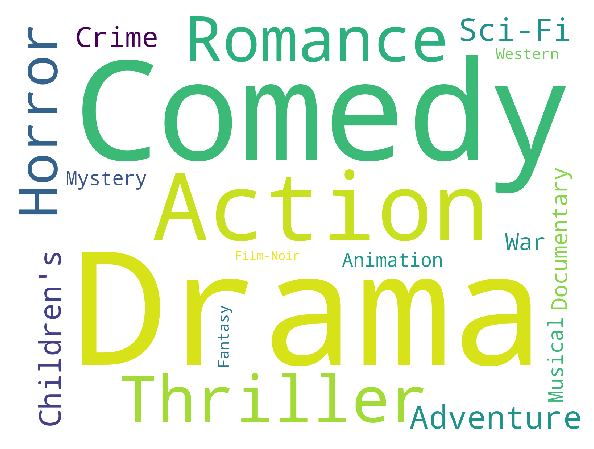

In [11]:
def multi_wordcloud(series):
    w=wc.WordCloud(background_color="white",margin=20,width=800,height=600,prefer_horizontal=0.7,max_words=20,scale=2)
    w.generate_from_frequencies(series)
    f, ax = plt.subplots(figsize=(16, 8))
    plt.axis('off')
    plt.imshow(w)
    plt.show()
    
#Apply the word cloud on the genres
multi_wordcloud(genres_count)

Drama and Comedy are dominants.

<br><br><br>
<br><br><br>
<br><br><br>
<br><br><br>
<br><br><br>
<br><br><br>

### Your goal: recover the cleared ratings with highest RMSE accuracy using a MATRIX COMPLETION method.
Sample 1000 of the given ratings matrix using seed of 123 and “clear them”. i.e., create a new ratings matrix without these samples



In [12]:
ratings_list = [i.strip().split("::") for i in open('ratings.dat', 'r').readlines()]
rating_df = pd.DataFrame(ratings_list, columns = ['UserID', 'MovieID', 'Rating', 'Timestamp'], dtype = int)
rating_df['Rating']=rating_df['Rating'].apply(pd.to_numeric)
rating_df.head()

UserID MovieID  Rating  Timestamp
0      1    1193       5  978300760
1      1     661       3  978302109
2      1     914       3  978301968
3      1    3408       4  978300275
4      1    2355       5  978824291

In [13]:
# random seed
np.random.seed(123)

# sample 1k
test_df = rating_df.sample(n=10)

# clear info
rating_df.loc[test_df.index,'Rating'] = 0 

test_df.head()

UserID MovieID  Rating  Timestamp
382276   2233     440       4  974597580
712314   4274     587       5  965301765
415052   2498     454       3  974089255
465169   2868    2336       5  992717615
270413   1636    2686       5  974962900

##### Additional instructions

- You may use the methods from class OR any other method you would like,but it must be a matrix completion method, namely a method which completes the given partially-observed matrix.  
- You may use the jupyter notebook uploaded in Lecture 8 for the pre-processing  
- You may use any programming language.  


#### Requirements for submission
- Your full implementation code (including the pre-processing steps above).  
- Resulting predictions and RMSE.  
- A short report summarizing your efforts and insights of the problem.  
- Bonus points will be given for creative approaches and ideas.  
- You are highly encouraged to consult, implement and use the SVT method, which was taught in class:
    - [CCS10] Jian-Feng Cai, Emmanuel J. Candes, and Zuowei Shen. A singular value threshold- ing algorithm for matrix completion. SIAM J. on Optimization, 20(4):1956–1982, March 2010.  
    - As mentioned in class- it may be very interesting to study and analyze the effect of the various parameters in this algorithm (e.g., delta) on the convergence, accuracy, etc.

# SVD - Exploratory  Analysis

##### unique users and movies

In [14]:
n_users = rating_df.UserID.unique().shape[0]
n_movies = rating_df.MovieID.unique().shape[0]
print('Number of users = ' + str(n_users))
print('Number of movies = ' + str(n_movies))

Number of users = 6040
Number of movies = 3706


##### ratings matrix
one row per user and one column per movie. 
To do so, I'll pivot ratings to get that and call the new variable Ratings.

In [15]:
Ratings = rating_df.pivot(index = 'UserID', columns ='MovieID', values = 'Rating').fillna(0)
Ratings.head()

MovieID    1   10  100  1000  1002  1003  1004  1005  1006  1007  ...   99  \
UserID                                                            ...        
1        5.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...  0.0   
10       5.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...  0.0   
100      0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...  0.0   
1000     5.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...  0.0   
1001     4.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...  0.0   

MovieID  990  991  992  993  994  996  997  998  999  
UserID                                                
1        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
10       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
100      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1000     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1001     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 3706 columns]

##### convert matrix from a dataframe to a numpy array

In [16]:
R = Ratings.values

##### normalize by each users mean

In [17]:
Ratings_means = np.mean(R, axis = 1)
Ratings_demeaned = R - Ratings_means.reshape(-1, 1)

##### Sparse?

In [18]:
print('The matrix percentage not sparse is ' + str(round((np.count_nonzero(Ratings)/Ratings.size)*100,2))+'%')

The matrix percentage not sparse is 4.47%


# SVD - implementation

In [45]:
from scipy.sparse.linalg import svds

#parameters 
param_k = 150

# UIV
U, sigma, Vt = svds(Ratings_demeaned, k = param_k)

# diagonal
sigma = np.diag(sigma)


In [46]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + Ratings_means.reshape(-1, 1)

In [47]:
preds = pd.DataFrame(all_user_predicted_ratings, columns = Ratings.columns)
preds.head()

MovieID         1        10       100      1000      1002      1003      1004  \
0        4.560131 -0.363389 -0.006448  0.022992 -0.018939  0.085378  0.157211   
1        4.457514  0.243641 -0.208224 -0.003125  0.040635  0.022912 -0.389413   
2       -0.029904  0.742917 -0.069864 -0.028280  0.034562 -0.056889  0.052089   
3        5.756884  0.060357 -0.039038 -0.037528 -0.005540 -0.097854 -0.068415   
4        3.998888  0.122983 -0.018625  0.200204  0.200991  0.024084 -0.111251   

MovieID      1005      1006      1007  ...        99       990       991  \
0       -0.054589  0.060187 -0.089692  ...  0.007192 -0.011498 -0.298679   
1        0.110345 -0.006182  1.187121  ... -0.209945 -0.170947  0.028559   
2       -0.134449  0.019794 -0.115345  ...  0.025529 -0.025871  0.208102   
3       -0.080656 -0.023594  0.012456  ...  0.062368 -0.071777 -0.214742   
4        0.051606  0.200878 -0.094283  ...  0.195698 -0.119503  1.175165   

MovieID       992       993       994       996       997       998       999  
0        0.039453 -0.008784 -0.334733  0.232111 -0.052144  0.003764  0.150326  
1        0.022334 -0.048363 -0.101280  0.061810 -0.117763 -0.319449 -0.276550  
2       -0.030538  0.019403  0.406297  0.105953  0.021752  0.001590  0.002239  
3       -0.045287 -0.034574  0.261329 -0.222291 -0.017956  0.101117 -0.273708  
4        0.117766  0.285298  0.878395 -0.217146  0.354642  0.189218  0.603470  

[5 rows x 3706 columns]

##### From decimal and negative numbers - Return to rating range values (1 to 5) and 0

This is a critical espect of the proccess. Due to values being negative, decimal and out of range.  
For example: There values as high as 10.  

Simultaneously, I argue that as long as the RMSE is good there is not actual statictical effect.  
After advising the web and my proffessors, there was no doubt - I should "correct" the values I got form the SVD .  
Also, if I want to keep the original values I sould prove that pissible of that action, and see if also the training data is kipping the RMSE error in check.  

Due to these reasons and more, I decided to correct the values as follows...

In [48]:
preds[preds.values<0]=0
preds[preds.values>5]=5
preds = round(preds)

##### Sparsity?

In [49]:
print('The matrix percentage not sparse is ' + str(round((np.count_nonzero(preds)/preds.size*100) ,2 ) )+'%')

The matrix percentage not sparse is 9.49%


### Check SVD Prediction

In [50]:
test_df.head()

UserID MovieID  Rating  Timestamp
382276   2233     440       4  974597580
712314   4274     587       5  965301765
415052   2498     454       3  974089255
465169   2868    2336       5  992717615
270413   1636    2686       5  974962900

In [51]:
preds.head()

MovieID    1   10  100  1000  1002  1003  1004  1005  1006  1007  ...   99  \
0        5.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...  0.0   
1        4.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0  ...  0.0   
2        0.0  1.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...  0.0   
3        5.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...  0.0   
4        4.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...  0.0   

MovieID  990  991  992  993  994  996  997  998  999  
0        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4        0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  

[5 rows x 3706 columns]

In [109]:
y_pred = test_df.apply(lambda row: preds[str(row.MovieID)][int(row.UserID)] ,axis=1).values
y_true = test_df.Rating.values

np.sqrt(MSE(y_pred,y_true))

3.847076812334269

## Generate the whole proccess

In [116]:
class my_SVD:
    
    def __init__(self,param_k=np.random.randint(1,1000),rating_path='ratings.dat',samples=1000,seed=123):
        import numpy as np
        import scipy as sp
        import pandas as pd
        
        from scipy.sparse.linalg import svds
        from sklearn.metrics import mean_squared_error as MSE
        
        self.k = param_k
        
        # dataframe
        ratings_list = [i.strip().split("::") for i in open(str(rating_path), 'r').readlines()]
        rating_df = pd.DataFrame(ratings_list, columns = ['UserID', 'MovieID', 'Rating', 'Timestamp'], dtype = int)
        rating_df['Rating']= rating_df['Rating'].apply(pd.to_numeric)
        self.df = rating_df.copy()

        # test train split
        np.random.seed(seed)
        self.test_df = self.df.sample(n=samples)
        self.df.loc[test_df.index,'Rating'] = 0 
        
        pass
        
    def preprocessing(self):
        self.ratings = self.df.pivot(index = 'UserID', columns ='MovieID', values = 'Rating').fillna(0)
        self.ratings_means = np.mean(self.ratings.values, axis = 1)
        self.ratings_demeaned = self.ratings.values - self.ratings_means.reshape(-1, 1)
        

    def fit(self):
        # UIV
        U, sigma, Vt = svds(self.ratings_demeaned, k = self.k)

        # diagonal
        sigma = np.diag(sigma)
        
        # preds
        all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + self.ratings_means.reshape(-1, 1)
        preds = pd.DataFrame(all_user_predicted_ratings, columns = self.ratings.columns)
        
        # supper important! #
        # otherwise, I will get minuses, values out of range, decimal values
        preds[preds.values<0]=0
        preds[preds.values>5]=5
        preds = round(preds)
        #####################
        
        self.predictions = preds

    def score(self):
        y_pred = self.test_df.apply(lambda row: self.predictions[str(row.MovieID)][int(row.UserID)] ,axis=1).values
        y_true = self.test_df.Rating.values

        return np.sqrt(MSE(y_true,y_pred))
    
    def fit_with_optimal_k(self,Ks):
        scores = []
        
        for k in Ks:
            self.k=k
            self.fit()
            scores.append(self.score())
        
        index_min = np.argmin(scores)
        self.k = Ks[index_min]
        self.fit()
        
        return scores


In [117]:
yoyo = my_SVD()
yoyo.preprocessing()

Ks = [10,25,50,75,100,125,150,175,200]
scores = yoyo.fit_with_optimal_k(Ks)

##### Show Results

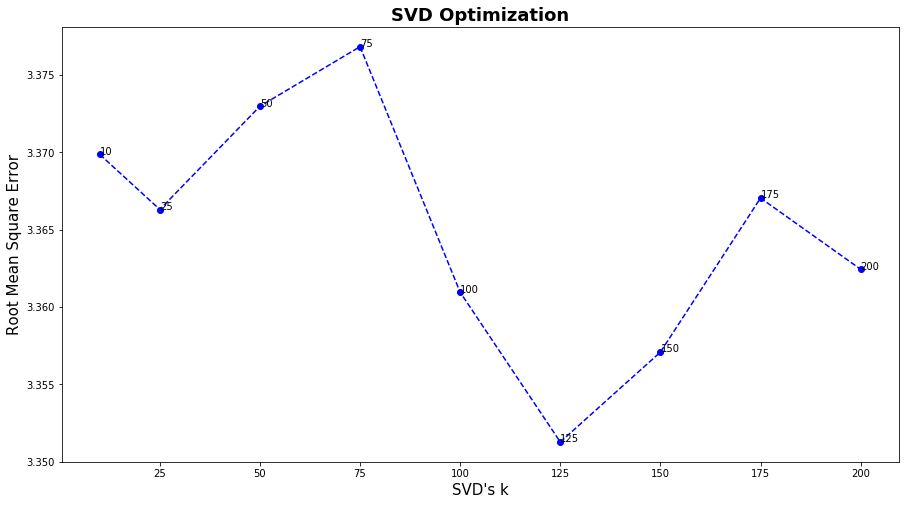

Optimal K is  125    with RMSE of:  3.35126841658498


In [118]:
fig, ax = plt.subplots(1,1,figsize=(15,8))

ax.plot(Ks, scores,linestyle='--', marker='o', color='b')
ax.set_title('SVD Optimization',fontweight="bold", size=18)
ax.set_xlabel('SVD\'s k',size=15)
ax.set_ylabel('Root Mean Square Error',size=15)

for i, txt in enumerate(Ks):
    ax.annotate(txt, (Ks[i], scores[i]))

plt.show()
print('Optimal K is ',yoyo.k,'   with RMSE of: ',yoyo.score())

##### Improve K?

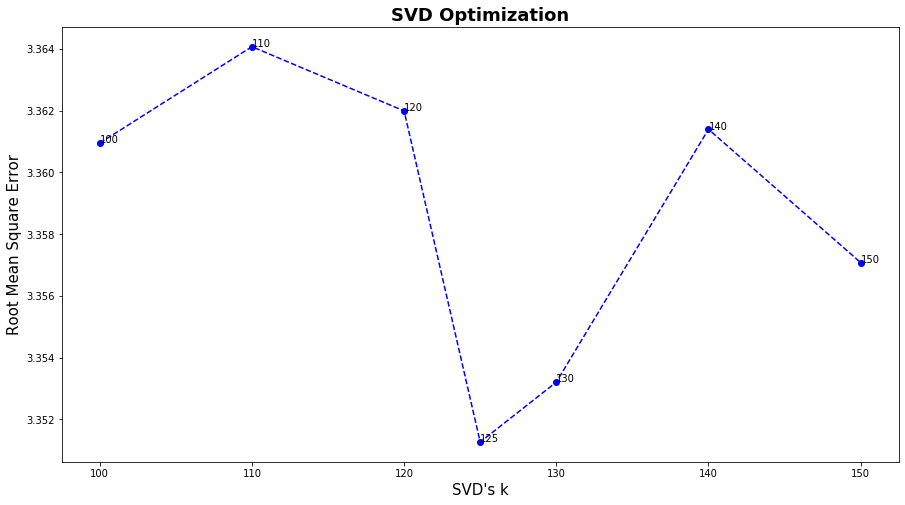

Optimal K is  125    with RMSE of:  3.35126841658498


In [125]:
# check next to the optimal range
Ks = [100,110,120,125,130,140,150]

# run SVD algorithm
scores = yoyo.fit_with_optimal_k(Ks)

# plot results
fig, ax = plt.subplots(1,1,figsize=(15,8))

ax.plot(Ks, scores,linestyle='--', marker='o', color='b')
ax.set_title('SVD Optimization',fontweight="bold", size=18)
ax.set_xlabel('SVD\'s k',size=15)
ax.set_ylabel('Root Mean Square Error',size=15)

for i, txt in enumerate(Ks):
    ax.annotate(txt, (Ks[i], scores[i]))

plt.show()
print('Optimal K is ',yoyo.k,'   with RMSE of: ',yoyo.score())

##### Improve K even more?

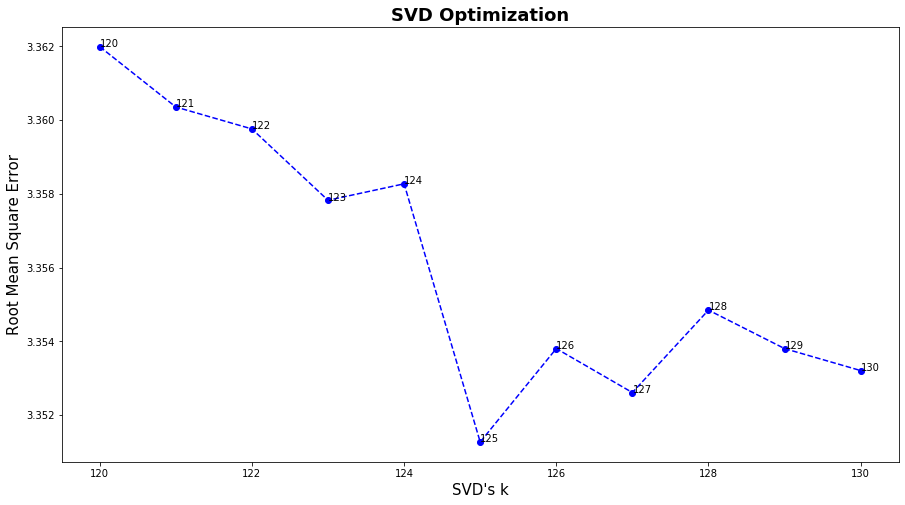

Optimal K is  125    with RMSE of:  3.35126841658498


In [126]:
# check next to the optimal range
Ks = np.arange(start=120,stop=131)

# run SVD algorithm
scores = yoyo.fit_with_optimal_k(Ks)

# plot results
fig, ax = plt.subplots(1,1,figsize=(15,8))

ax.plot(Ks, scores,linestyle='--', marker='o', color='b')
ax.set_title('SVD Optimization',fontweight="bold", size=18)
ax.set_xlabel('SVD\'s k',size=15)
ax.set_ylabel('Root Mean Square Error',size=15)

for i, txt in enumerate(Ks):
    ax.annotate(txt, (Ks[i], scores[i]))

plt.show()
print('Optimal K is ',yoyo.k,'   with RMSE of: ',yoyo.score())

#### Bonus concept: accuracy, precision, recall

In [127]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

y_pred = yoyo.test_df.apply(lambda row: yoyo.predictions[str(row.MovieID)][int(row.UserID)] ,axis=1).values
y_true = yoyo.test_df.Rating.values

print(classification_report(y_true,y_pred))
print('accuracy = ' , accuracy_score(y_true,y_pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       0.03      0.11      0.05        45
         2.0       0.07      0.03      0.04       120
         3.0       0.14      0.01      0.03       276
         4.0       0.29      0.02      0.04       332
         5.0       0.28      0.02      0.04       227

    accuracy                           0.03      1000
   macro avg       0.13      0.03      0.03      1000
weighted avg       0.21      0.03      0.04      1000

accuracy =  0.026


#### Conclutions:
- As shown in the Classification Report there is no point of using a traditional accuracy metrics, and the ussage of metric such as RMSE,MSE,etc are the corrent estimation of our matrix factorization techniques.
- In this dataset K values has some monotonicity, but There is no guarantee due to local minima and local maxima.
- In this dataset k=61 had the minimal(best) RMSE.




<br><br><br><br>
<br><br><br><br>
<br><br><br><br>
<br><br><br><br>

# SVT

##### I'm refering my answer on this well writen articles:  
 
SVT: Singular Value Thresholding in MATLAB  
https://www.jstatsoft.org/article/view/v081c02/v81c02.pdf  

Jian-Feng Cai, Emmanuel J. Candès, and Zuowei Shen. 2010. A Singular Value Thresholding Algorithm for Matrix Completion. SIAM J. on Optimization 20, 4 (March 2010), 1956-1982.  
http://dx.doi.org/10.1137/080738970    

<br><br>  

##### And these implementations:  
Singular Value Thresholding "SVT" (legacy code), taken from the SVT website svt.stanford.edu  
https://github.com/stephenbeckr/SVT  

Lightweight Python library for in-memory matrix completion.    
https://github.com/tonyduan/matrix-completion  




<br><br>
<br><br>

In [263]:
class my_SVT():
    
    def __init__(self,k,max_iterations=10,tau=0.5,delta=0.5,epsilon=0.001,rating_path='ratings.dat',samples=1000,seed=123):
        import numpy as np
        import scipy as sp
        import pandas as pd
        
        from scipy.sparse.linalg import svds
        from sklearn.metrics import mean_squared_error as MSE
        
        # dataframe
        ratings_list = [i.strip().split("::") for i in open(str(rating_path), 'r').readlines()]
        rating_df = pd.DataFrame(ratings_list, columns = ['UserID', 'MovieID', 'Rating', 'Timestamp'], dtype = int)
        rating_df['Rating']= rating_df['Rating'].apply(pd.to_numeric)
        self.df = rating_df.copy()

        # test train split
        np.random.seed(seed)
        self.test_df = self.df.sample(n=samples)
        self.df.loc[self.test_df.index,'Rating'] = 0 
        
        # set params
        self.k = k
        self.max_iterations = max_iterations
        self.tau = tau
        self.delta = delta
        self.epsilon = epsilon
                    
    def preprocessing(self):
        self.ratings = self.df.pivot(index = 'UserID', columns ='MovieID', values = 'Rating').fillna(0)
        self.ratings_means = np.mean(self.ratings.values, axis = 1)
        self.A = self.ratings.values - self.ratings_means.reshape(-1, 1)

        self.Y = np.zeros_like(self.A)
        self.mask = (self.A > 0 ) + 0 
    
    def fit(self):
        iterations = {}
        for iteration in range(self.max_iterations):
            U, S, V = sp.sparse.linalg.svds(self.Y,k=self.k)
            S = np.maximum(S - self.tau, 0)
            X = np.linalg.multi_dot(([U, np.diag(S), V]))
            self.Y += self.delta * self.mask * (self.A - X)

            recon_error = np.linalg.norm(self.mask * (X - self.A)) / np.linalg.norm(self.mask * self.A)
            iterations[iteration] = recon_error
            
            if recon_error < self.epsilon:
                break

        self.X = X
        return iterations
    
    def score(self):
        preds = pd.DataFrame(self.X + self.A, columns = self.ratings.columns)
        
         # supper important! #
        preds[preds.values<0]=0
        preds[preds.values>5]=5
        predictions = round(preds)
        #####################
        
        y_pred = self.test_df.apply(lambda row: predictions[str(row.MovieID)][int(row.UserID)] ,axis=1).values
        y_true = self.test_df.Rating.values
        
        return np.sqrt(MSE(y_true,y_pred))

    def fit_with_optimal_tau_and_delta(self,TAUs,DELTAs):

        df = pd.DataFrame(columns=['Delta','Tau','Score','Iterations'])
        iteration = 0
                
        for d in DELTAs:
            for t in TAUs:
                iteration = iteration+1
                
                # change params
                self.delta = d
                self.tau = t
                
                iterations_score = self.fit()
                score = self.score()
                
                df.loc[iteration] = [d,t,score,iterations_score]
                print('delta=',self.delta,'  tau=',self.tau,'   ..')
                print('Final score = ',score)
                print()

        return df
    


##### Search for optimal params

In [267]:
k_optimal = 125
ds = [0.25,0.5,1,2]
ts = [0.5,1,2,4]

# create 
popo = my_SVT(k_optimal,max_iterations=15)

# preprocessing
popo.preprocessing()

# find optimal params
df_svt = popo.fit_with_optimal_tau_and_delta(TAUs=ts,DELTAs=ds)

delta= 0.25   tau= 0.5    ..
Final score =  3.19280440991928

delta= 0.25   tau= 1    ..
Final score =  3.0820447757941483

delta= 0.25   tau= 2    ..
Final score =  3.01711782998278

delta= 0.25   tau= 4    ..
Final score =  3.034633421024688

delta= 0.5   tau= 0.5    ..
Final score =  2.9765752132274432

delta= 0.5   tau= 1    ..
Final score =  2.961756235749323

delta= 0.5   tau= 2    ..
Final score =  2.9383668933610045

delta= 0.5   tau= 4    ..
Final score =  2.9111853256019273

delta= 1   tau= 0.5    ..
Final score =  2.9015513092137453

delta= 1   tau= 1    ..
Final score =  2.936494508763808

delta= 1   tau= 2    ..
Final score =  2.9524566042534817

delta= 1   tau= 4    ..
Final score =  2.939897957412808

delta= 2   tau= 0.5    ..
Final score =  2.9521178838251023

delta= 2   tau= 1    ..
Final score =  2.9760712357065646

delta= 2   tau= 2    ..
Final score =  2.9718680993610738

delta= 2   tau= 4    ..
Final score =  2.9587159377000014



In [271]:
df_svt

Delta  Tau     Score                                         Iterations
1    0.25  0.5  3.192804  {0: 1.0000000000000029, 1: 0.8625832791509733,...
2    0.25  1.0  3.082045  {0: 0.37269644727375817, 1: 0.3659539875370451...
3    0.25  2.0  3.017118  {0: 0.34516348326637664, 1: 0.3461552442067643...
4    0.25  4.0  3.034633  {0: 0.3609161763786982, 1: 0.3612432570049416,...
5    0.50  0.5  2.976575  {0: 0.3818999823968777, 1: 0.43446748797184404...
6    0.50  1.0  2.961756  {0: 0.4269478944418517, 1: 0.4276069482086793,...
7    0.50  2.0  2.938367  {0: 0.4398386596458495, 1: 0.4417459555429655,...
8    0.50  4.0  2.911185  {0: 0.44825276679764137, 1: 0.4484173024785339...
9    1.00  0.5  2.901551  {0: 0.4601243739245118, 1: 0.5594043822241844,...
10   1.00  1.0  2.936495  {0: 0.5008858583700976, 1: 0.5011557302897224,...
11   1.00  2.0  2.952457  {0: 0.4990692535722709, 1: 0.49793770158739664...
12   1.00  4.0  2.939898  {0: 0.4978189680284659, 1: 0.49751257274688754...
13   2.00  0.5  2.952118  {0: 0.5048104653475877, 1: 0.7021286305041307,...
14   2.00  1.0  2.976071  {0: 0.6377399659943616, 1: 0.6426362631694891,...
15   2.00  2.0  2.971868  {0: 0.6429591123046381, 1: 0.6376254230978623,...
16   2.00  4.0  2.958716  {0: 0.6387633438386408, 1: 0.6392423305014313,...

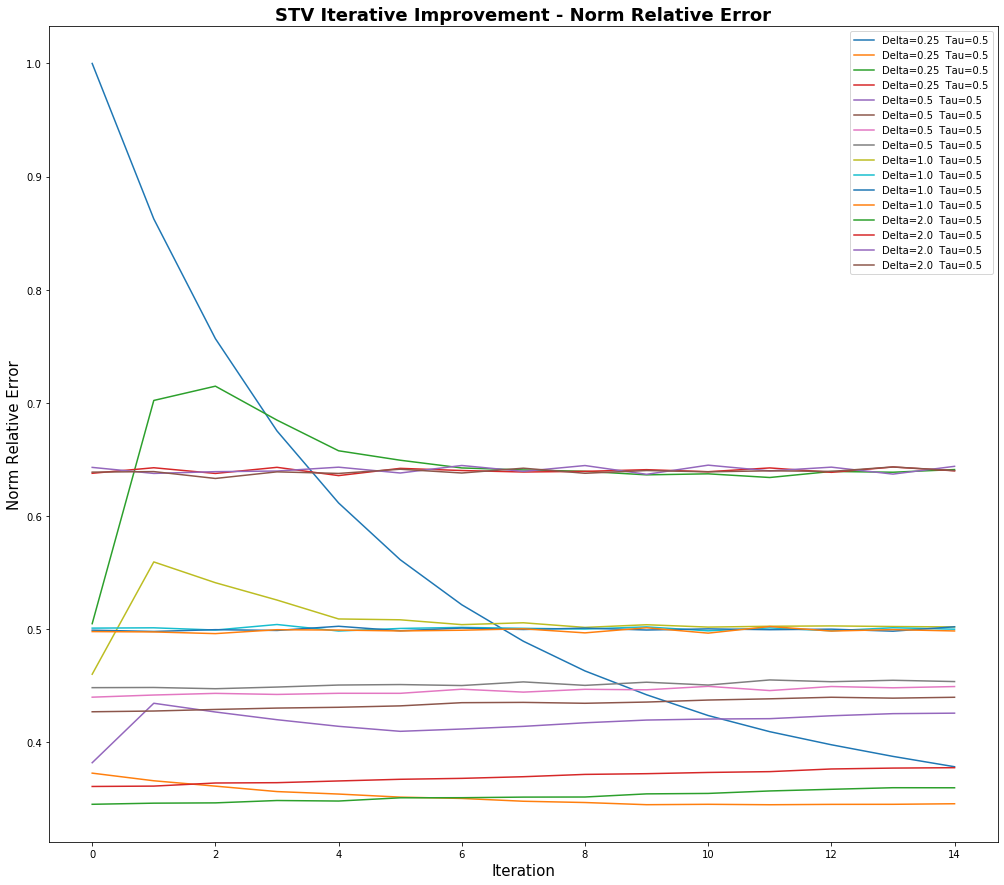

In [294]:
plt.figure(figsize=(17,15))

for i in range(len(df_svt)) :
    plt.plot(list(df_svt.iloc[i].Iterations.values()), label='Delta={0}  Tau={1}'.format(df_svt.iloc[i].Delta,df_svt.iloc[0].Tau))

plt.title('STV Iterative Improvement - Norm Relative Error',fontweight="bold", size=18)
plt.xlabel('Iteration',size=15)
plt.ylabel('Norm Relative Error',size=15)
plt.legend()    
plt.show()

##### SVT - Optimal params

In [293]:
print('\nOptimal with number of iterations: ',len(df_svt.iloc[df_svt.Score.nsmallest(1).index].Iterations.values[0]),)
df_svt.iloc[df_svt.Score.nsmallest(1).index]


Optimal with number of iterations:  15


Delta  Tau     Score                                         Iterations
10    1.0  1.0  2.936495  {0: 0.5008858583700976, 1: 0.5011557302897224,...

#### Conclutions:
- The same as SVD's Classification Report, there is no point of using a traditional accuracy metrics, and the ussage of metric such as NRE,RMSE,MSE,etc are the corrent estimation of our matrix factorization techniques.
- Used Norm Relative Error betweento messure improvement between iterations, that shows improvement, but the RMSE did not improved that much. Also, apperently NRE and RMSE do not have a high correletion. I assume it's due to NRE is just an estimation and not a real error calculation.
- In this dataset Delta=1,Tau=1,k=125,Iteration=15 had the minimal(best) RMSE.

<br><br>
<br><br>

## My Main Conclution:
#### Singular Value Thresholding does a better job then Singular Value Decomposition.